In [1]:

# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from scipy.signal import find_peaks, butter, filtfilt
from wfdb.processing import XQRS

# Add the parent directory to the path to import project modules
sys.path.append('..')
from src import peak_detection, data_processing

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
# %% Cell 2: Load Processed ECG Data
# Try to load previously processed data
try:
    processed_file = '../data/processed/ecg_signal.csv'
    df = pd.read_csv(processed_file)
    
    # Extract time and signal data
    time = df['Time (s)'].values
    
    # Detect channel columns
    channel_cols = [col for col in df.columns if col.startswith('Channel_')]
    
    if channel_cols:
        ecg_signal = df[channel_cols].values
        print(f"Loaded {len(channel_cols)} channels from {processed_file}")
    else:
        raise ValueError("No channel columns found")
    
    # Estimate sampling frequency
    fs = int(1 / (time[1] - time[0]))
    print(f"Estimated sampling frequency: {fs} Hz")
    
except Exception as e:
    print(f"Error loading processed data: {e}")
    
    # Generate synthetic data as fallback
    print("Creating synthetic ECG data...")
    fs = 250  # Hz
    duration = 10  # seconds
    
    # Time array
    time = np.arange(0, duration, 1/fs)
    
    # Create synthetic ECG with 12 heartbeats (approximately 72 BPM)
    ecg_signal = np.zeros((len(time), 2))  # Two channels
    
    # Create synthetic heartbeats
    for i in range(12):
        t_center = i * 0.83
        # QRS complex
        qrs_mask = (time > t_center - 0.03) & (time < t_center + 0.03)
        ecg_signal[qrs_mask, 0] = 1.5 * np.sin((time[qrs_mask] - t_center) * 150 + np.pi/2)
        ecg_signal[qrs_mask, 1] = 1.2 * np.sin((time[qrs_mask] - t_center) * 150 + np.pi/2)
        
        # P wave
        p_center = t_center - 0.15
        p_mask = (time > p_center - 0.05) & (time < p_center + 0.05)
        ecg_signal[p_mask, 0] += 0.25 * np.sin((time[p_mask] - p_center) * 100 + np.pi/2)
        ecg_signal[p_mask, 1] += 0.2 * np.sin((time[p_mask] - p_center) * 100 + np.pi/2)
        
        # T wave
        t_center = t_center + 0.2
        t_mask = (time > t_center - 0.1) & (time < t_center + 0.1)
        ecg_signal[t_mask, 0] += 0.35 * np.sin((time[t_mask] - t_center) * 50 + np.pi/2)
        ecg_signal[t_mask, 1] += 0.3 * np.sin((time[t_mask] - t_center) * 50 + np.pi/2)
    
    # Add noise
    ecg_signal[:, 0] += np.random.normal(0, 0.05, len(time))
    ecg_signal[:, 1] += np.random.normal(0, 0.04, len(time))


Loaded 2 channels from ../data/processed/ecg_signal.csv
Estimated sampling frequency: 360 Hz


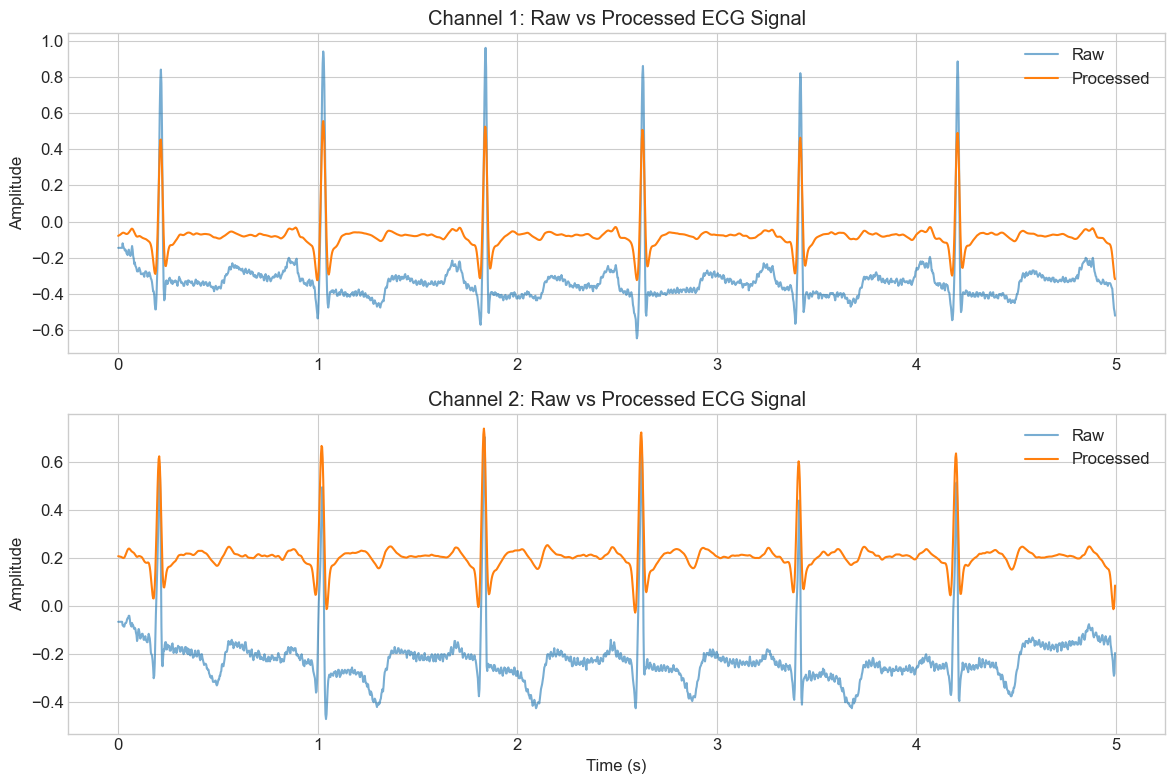

In [4]:

# Cell 3: Preprocess ECG Signal (Fixed Version)
# Modified preprocessing function that handles short signals
def preprocess_ecg(signal, fs=250, lowcut=5, highcut=30, powerline_freq=50):
    """Complete ECG preprocessing pipeline with handling for short signals."""
    # Make a copy of the input signal
    signal_filtered = signal.copy()
    
    try:
        # Check signal dimensions
        if signal.ndim > 1:  # Multi-channel
            for channel in range(signal.shape[1]):
                # Apply processing to each channel if long enough
                channel_data = signal[:, channel]
                
                # 1. Remove baseline wander (with exception handling)
                try:
                    channel_data = data_processing.remove_baseline_wander(channel_data, fs)
                except ValueError as e:
                    print(f"Warning: Baseline wander removal failed: {e}")
                    # Continue with original data
                
                # 2. Remove powerline interference
                try:
                    channel_data = data_processing.remove_powerline_interference(channel_data, fs, powerline_freq)
                except ValueError as e:
                    print(f"Warning: Powerline removal failed: {e}")
                
                # 3. Apply bandpass filter
                try:
                    channel_data = data_processing.bandpass_filter(channel_data, lowcut, highcut, fs)
                except ValueError as e:
                    print(f"Warning: Bandpass filtering failed: {e}")
                
                # 4. Normalize
                channel_data = 2 * (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data)) - 1
                
                # Store processed channel
                signal_filtered[:, channel] = channel_data
        else:  # Single channel
            # Apply each processing step with exception handling
            try:
                signal_filtered = data_processing.remove_baseline_wander(signal_filtered, fs)
            except ValueError as e:
                print(f"Warning: Baseline wander removal failed: {e}")
            
            try:
                signal_filtered = data_processing.remove_powerline_interference(signal_filtered, fs, powerline_freq)
            except ValueError as e:
                print(f"Warning: Powerline removal failed: {e}")
            
            try:
                signal_filtered = data_processing.bandpass_filter(signal_filtered, lowcut, highcut, fs)
            except ValueError as e:
                print(f"Warning: Bandpass filtering failed: {e}")
            
            # Normalize
            signal_filtered = 2 * (signal_filtered - np.min(signal_filtered)) / (np.max(signal_filtered) - np.min(signal_filtered)) - 1
            
    except Exception as e:
        print(f"Warning: Signal processing failed: {e}")
        print("Falling back to simple normalization")
        # Fall back to just normalization if all else fails
        if signal.ndim > 1:  # Multi-channel
            for channel in range(signal.shape[1]):
                channel_data = signal[:, channel]
                signal_filtered[:, channel] = 2 * (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data)) - 1
        else:  # Single channel
            signal_filtered = 2 * (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) - 1
            
    return signal_filtered
    
# Process all channels with the fixed function
ecg_processed = preprocess_ecg(ecg_signal, fs)

# Plot first 5 seconds
duration = 5  # seconds
samples = min(int(duration * fs), ecg_signal.shape[0])

plt.figure(figsize=(12, 8))
for channel in range(ecg_signal.shape[1]):
    plt.subplot(ecg_signal.shape[1], 1, channel+1)
    plt.plot(time[:samples], ecg_signal[:samples, channel], label="Raw", alpha=0.6)
    plt.plot(time[:samples], ecg_processed[:samples, channel], label="Processed", linewidth=1.5)
    plt.title(f"Channel {channel+1}: Raw vs Processed ECG Signal")
    plt.xlabel("Time (s)" if channel == ecg_signal.shape[1]-1 else "")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# %% Cell 4: R-Peak Detection using Pan-Tompkins algorithm
def detect_r_peaks_pan_tompkins(ecg_signal, fs):
    """
    Detect R-peaks using the Pan-Tompkins algorithm.
    
    Parameters:
        ecg_signal: The ECG signal
        fs: Sampling frequency
        
    Returns:
        Array of R-peak indices
    """
    # If multi-channel, use the first channel
    if ecg_signal.ndim > 1:
        signal = ecg_signal[:, 0]
    else:
        signal = ecg_signal
    
    # Differentiation
    diff_signal = np.diff(signal)
    
    # Squaring
    squared_signal = diff_signal ** 2
    
    # Moving Average (Integration)
    window_size = int(0.15 * fs)  # 150 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode="same")
    
    # Adaptive thresholding could be added here
    threshold = 0.3 * np.max(integrated_signal)
    
    # Find peaks
    peaks, _ = find_peaks(integrated_signal, height=threshold, distance=int(0.2 * fs))
    
    # Adjust peak locations to actual R-peaks
    r_peaks = []
    for peak in peaks:
        # Search for maximum in a small window around the detected peak
        window_start = max(0, peak - int(0.05 * fs))
        window_end = min(len(signal), peak + int(0.05 * fs))
        r_peak = window_start + np.argmax(signal[window_start:window_end])
        r_peaks.append(r_peak)
    
    return np.array(r_peaks)


In [6]:
# %% Cell 5: R-Peak Detection using XQRS algorithm
def detect_r_peaks_xqrs(ecg_signal, fs):
    """
    Detect R-peaks using the XQRS algorithm from WFDB.
    
    Parameters:
        ecg_signal: The ECG signal
        fs: Sampling frequency
        
    Returns:
        Array of R-peak indices
    """
    # If multi-channel, use the first channel
    if ecg_signal.ndim > 1:
        signal = ecg_signal[:, 0]
    else:
        signal = ecg_signal
    
    # Initialize XQRS detector
    xqrs = XQRS(sig=signal, fs=fs)
    
    # Detect peaks
    xqrs.detect()
    
    # Get detected peak indices
    r_peaks = xqrs.qrs_inds
    
    return r_peaks

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Pan-Tompkins: 2272 R-peaks detected
XQRS: 2273 R-peaks detected


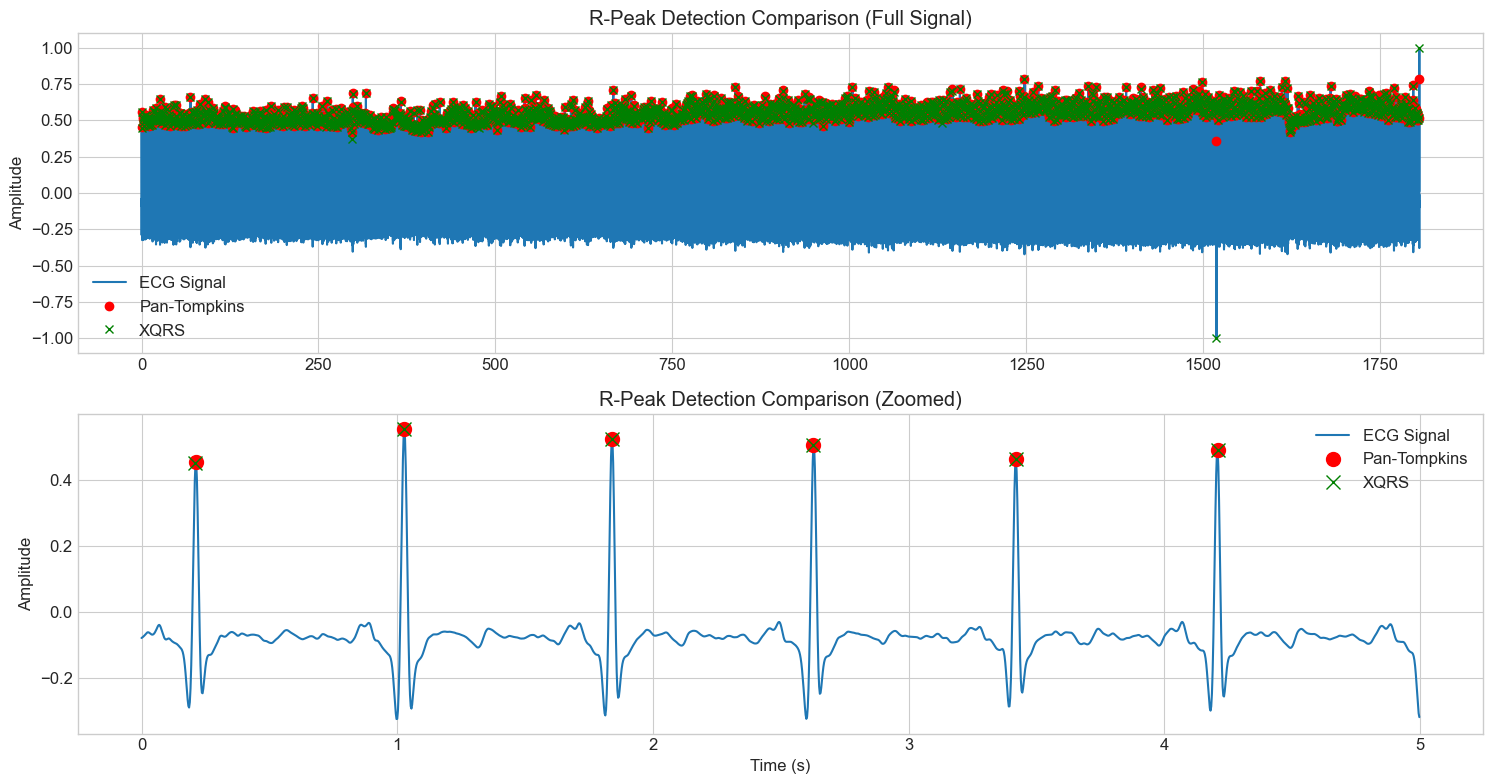

In [7]:
# %% Cell 6: Compare R-Peak Detection Methods
# Detect R-peaks using both methods
channel_to_analyze = 0  # Analyze the first channel

r_peaks_pt = detect_r_peaks_pan_tompkins(ecg_processed[:, channel_to_analyze], fs)
r_peaks_xqrs = detect_r_peaks_xqrs(ecg_processed[:, channel_to_analyze], fs)

print(f"Pan-Tompkins: {len(r_peaks_pt)} R-peaks detected")
print(f"XQRS: {len(r_peaks_xqrs)} R-peaks detected")

# Plot comparison
plt.figure(figsize=(15, 8))

# Plot full signal with detected peaks
plt.subplot(2, 1, 1)
plt.plot(time, ecg_processed[:, channel_to_analyze], label="ECG Signal")
plt.plot(time[r_peaks_pt], ecg_processed[r_peaks_pt, channel_to_analyze], 'ro', label="Pan-Tompkins")
plt.plot(time[r_peaks_xqrs], ecg_processed[r_peaks_xqrs, channel_to_analyze], 'gx', label="XQRS")
plt.title("R-Peak Detection Comparison (Full Signal)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot zoomed section (first 5 seconds)
plt.subplot(2, 1, 2)
plt.plot(time[:samples], ecg_processed[:samples, channel_to_analyze], label="ECG Signal")
# Filter peaks within the zoomed window
pt_peaks_in_window = r_peaks_pt[r_peaks_pt < samples]
xqrs_peaks_in_window = r_peaks_xqrs[r_peaks_xqrs < samples]
plt.plot(time[pt_peaks_in_window], ecg_processed[pt_peaks_in_window, channel_to_analyze], 'ro', label="Pan-Tompkins", markersize=10)
plt.plot(time[xqrs_peaks_in_window], ecg_processed[xqrs_peaks_in_window, channel_to_analyze], 'gx', label="XQRS", markersize=10)
plt.title("R-Peak Detection Comparison (Zoomed)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Average Heart Rate (Pan-Tompkins): 75.8 BPM
Average Heart Rate (XQRS): 75.8 BPM


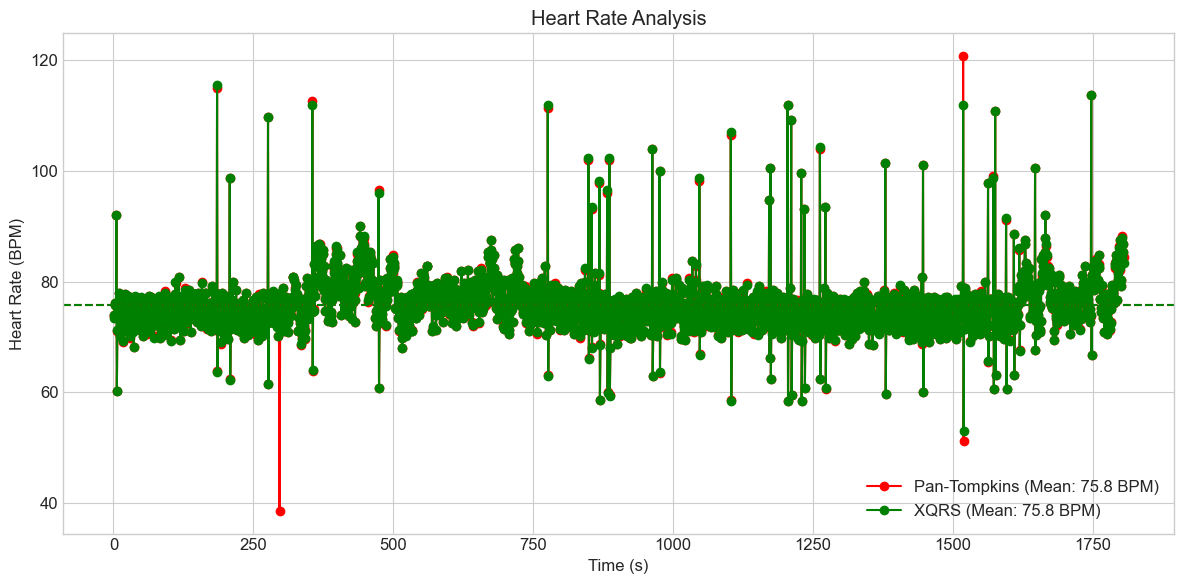

In [8]:
# %% Cell 7: Calculate Heart Rate from R-peaks
def calculate_heart_rate(r_peaks, fs, window_size=3):
    """
    Calculate instantaneous heart rate from R-peak indices.
    
    Parameters:
        r_peaks: Array of R-peak indices
        fs: Sampling frequency
        window_size: Window size in seconds for calculating average heart rate
        
    Returns:
        times: Time points for heart rate measurements
        heart_rates: Instantaneous heart rate in BPM
    """
    # Calculate RR intervals in seconds
    rr_intervals = np.diff(r_peaks) / fs
    
    # Convert to BPM
    inst_heart_rates = 60 / rr_intervals
    
    # Time points for heart rate (at the midpoint of each RR interval)
    hr_times = time[r_peaks[:-1]] + rr_intervals / 2
    
    return hr_times, inst_heart_rates

# Calculate heart rate from R-peaks
hr_times_pt, heart_rates_pt = calculate_heart_rate(r_peaks_pt, fs)
hr_times_xqrs, heart_rates_xqrs = calculate_heart_rate(r_peaks_xqrs, fs)

# Calculate average heart rates
avg_hr_pt = np.mean(heart_rates_pt)
avg_hr_xqrs = np.mean(heart_rates_xqrs)

print(f"Average Heart Rate (Pan-Tompkins): {avg_hr_pt:.1f} BPM")
print(f"Average Heart Rate (XQRS): {avg_hr_xqrs:.1f} BPM")

# Plot heart rate
plt.figure(figsize=(12, 6))
plt.plot(hr_times_pt, heart_rates_pt, 'ro-', label=f"Pan-Tompkins (Mean: {avg_hr_pt:.1f} BPM)")
plt.plot(hr_times_xqrs, heart_rates_xqrs, 'go-', label=f"XQRS (Mean: {avg_hr_xqrs:.1f} BPM)")
plt.axhline(y=avg_hr_pt, color='r', linestyle='--')
plt.axhline(y=avg_hr_xqrs, color='g', linestyle='--')
plt.title("Heart Rate Analysis")
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# %% Cell 8: PQRST Detection 
def detect_pqrst_peaks(ecg_signal, r_peaks, fs):
    """
    Detect P, Q, S, and T peaks based on R-peaks.
    
    Parameters:
        ecg_signal: The ECG signal
        r_peaks: Array of R-peak indices
        fs: Sampling frequency
        
    Returns:
        Dictionary of P, Q, R, S, and T peak indices
    """
    p_peaks, q_peaks, s_peaks, t_peaks = [], [], [], []
    
    for r_peak in r_peaks:
        # Q-wave: Look for minimum before R-peak
        q_start = max(0, r_peak - int(0.05 * fs))  # 50 ms before R
        q_end = r_peak
        if q_start < q_end:
            q_index = q_start + np.argmin(ecg_signal[q_start:q_end])
            q_peaks.append(q_index)
        
        # S-wave: Look for minimum after R-peak
        s_start = r_peak
        s_end = min(len(ecg_signal), r_peak + int(0.05 * fs))  # 50 ms after R
        if s_start < s_end:
            s_index = s_start + np.argmin(ecg_signal[s_start:s_end])
            s_peaks.append(s_index)
        
        # P-wave: Look for maximum before Q-wave
        if len(q_peaks) > 0:
            p_start = max(0, q_peaks[-1] - int(0.15 * fs))  # 150 ms before Q
            p_end = q_peaks[-1]
            if p_start < p_end:
                p_index = p_start + np.argmax(ecg_signal[p_start:p_end])
                p_peaks.append(p_index)
        
        # T-wave: Look for maximum after S-wave
        if len(s_peaks) > 0:
            t_start = s_peaks[-1]
            t_end = min(len(ecg_signal), s_peaks[-1] + int(0.3 * fs))  # 300 ms after S
            if t_start < t_end:
                t_index = t_start + np.argmax(ecg_signal[t_start:t_end])
                t_peaks.append(t_index)
    
    # Package results
    pqrst_peaks = {
        'P': np.array(p_peaks),
        'Q': np.array(q_peaks),
        'R': np.array(r_peaks),
        'S': np.array(s_peaks),
        'T': np.array(t_peaks)
    }
    
    return pqrst_peaks

# Use XQRS R-peaks for PQRST detection
channel_to_analyze = 0  # Analyze the first channel
pqrst_peaks = detect_pqrst_peaks(ecg_processed[:, channel_to_analyze], r_peaks_xqrs, fs)

# Print number of detected waves
for wave, indices in pqrst_peaks.items():
    print(f"{wave}-wave: {len(indices)} detected")


P-wave: 2273 detected
Q-wave: 2273 detected
R-wave: 2273 detected
S-wave: 2273 detected
T-wave: 2273 detected


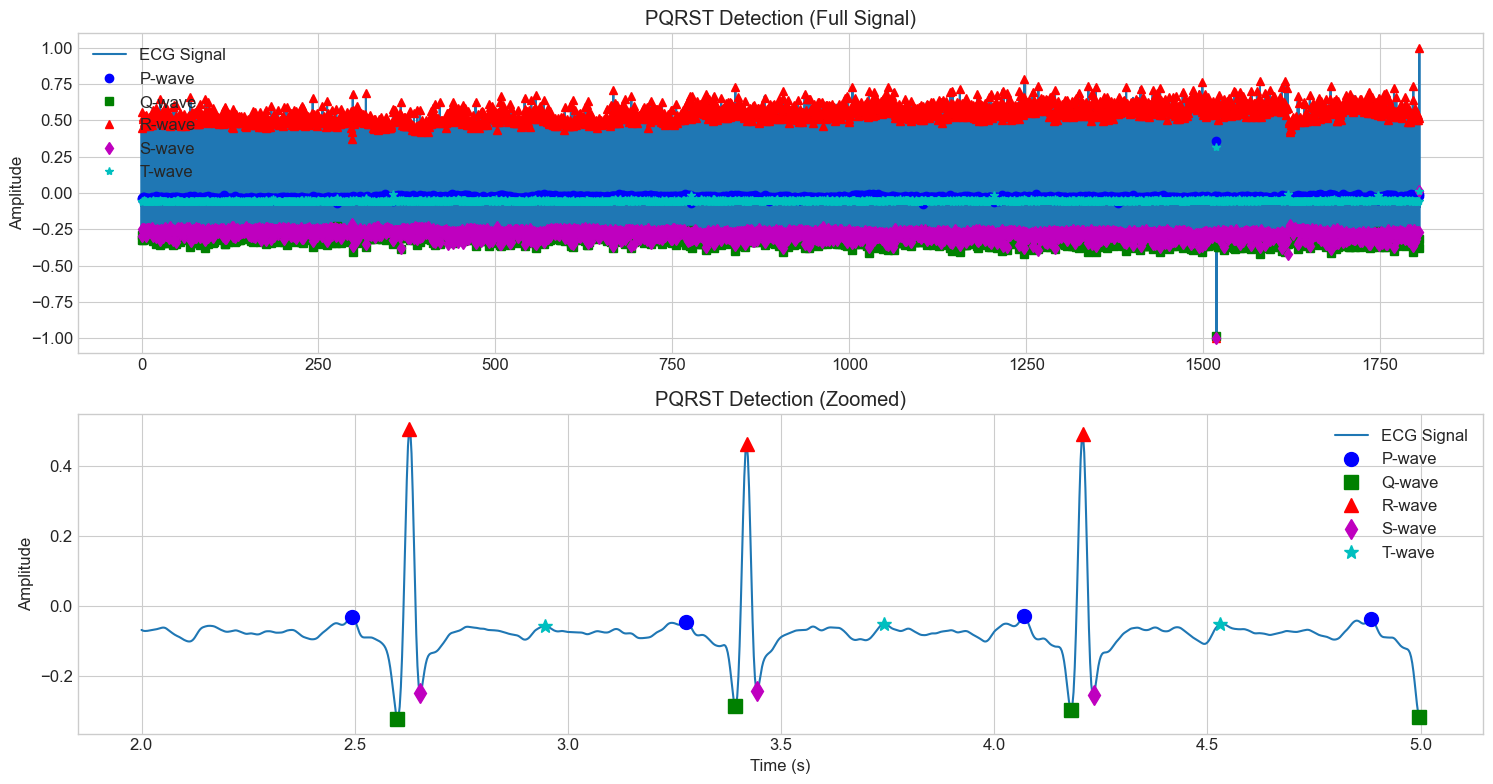

In [10]:
# %% Cell 9: Visualize PQRST Detection
# Plot full signal with all detected peaks
plt.figure(figsize=(15, 8))

# Define colors and markers for each wave
wave_colors = {'P': 'b', 'Q': 'g', 'R': 'r', 'S': 'm', 'T': 'c'}
wave_markers = {'P': 'o', 'Q': 's', 'R': '^', 'S': 'd', 'T': '*'}

# Plot full signal
plt.subplot(2, 1, 1)
plt.plot(time, ecg_processed[:, channel_to_analyze], label="ECG Signal")
for wave, indices in pqrst_peaks.items():
    plt.plot(time[indices], ecg_processed[indices, channel_to_analyze], 
             wave_colors[wave] + wave_markers[wave], label=f"{wave}-wave")
plt.title("PQRST Detection (Full Signal)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot zoomed section (3 seconds)
zoom_start = 2  # start at 2 seconds
zoom_end = 5    # end at 5 seconds
zoom_start_idx = int(zoom_start * fs)
zoom_end_idx = int(zoom_end * fs)

plt.subplot(2, 1, 2)
plt.plot(time[zoom_start_idx:zoom_end_idx], 
         ecg_processed[zoom_start_idx:zoom_end_idx, channel_to_analyze], 
         label="ECG Signal")

for wave, indices in pqrst_peaks.items():
    # Filter indices within the zoomed window
    indices_in_window = indices[(indices >= zoom_start_idx) & (indices < zoom_end_idx)]
    plt.plot(time[indices_in_window], ecg_processed[indices_in_window, channel_to_analyze], 
             wave_colors[wave] + wave_markers[wave], label=f"{wave}-wave", markersize=10)

plt.title("PQRST Detection (Zoomed)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# %% Cell 10: Calculate ECG Intervals
def calculate_ecg_intervals(pqrst_peaks, fs):
    """
    Calculate important ECG intervals from PQRST peaks.
    
    Parameters:
        pqrst_peaks: Dictionary of P, Q, R, S, and T peak indices
        fs: Sampling frequency
        
    Returns:
        Dictionary of ECG intervals in milliseconds
    """
    intervals = {}
    
    # Convert from samples to milliseconds
    ms_factor = 1000 / fs
    
    # RR intervals (time between consecutive R peaks)
    if len(pqrst_peaks['R']) > 1:
        rr_intervals = np.diff(pqrst_peaks['R']) * ms_factor
        intervals['RR'] = rr_intervals
        intervals['RR_mean'] = np.mean(rr_intervals)
        intervals['RR_std'] = np.std(rr_intervals)
        
    # PR interval (from P to R)
    pr_intervals = []
    for i in range(min(len(pqrst_peaks['P']), len(pqrst_peaks['R']))):
        if i < len(pqrst_peaks['P']) and i < len(pqrst_peaks['R']):
            pr_intervals.append((pqrst_peaks['R'][i] - pqrst_peaks['P'][i]) * ms_factor)
    if pr_intervals:
        intervals['PR'] = np.array(pr_intervals)
        intervals['PR_mean'] = np.mean(pr_intervals)
        intervals['PR_std'] = np.std(pr_intervals)
    
    # QRS duration (from Q to S)
    qrs_durations = []
    for i in range(min(len(pqrst_peaks['Q']), len(pqrst_peaks['S']))):
        if i < len(pqrst_peaks['Q']) and i < len(pqrst_peaks['S']):
            qrs_durations.append((pqrst_peaks['S'][i] - pqrst_peaks['Q'][i]) * ms_factor)
    if qrs_durations:
        intervals['QRS'] = np.array(qrs_durations)
        intervals['QRS_mean'] = np.mean(qrs_durations)
        intervals['QRS_std'] = np.std(qrs_durations)
    
    # QT interval (from Q to T)
    qt_intervals = []
    for i in range(min(len(pqrst_peaks['Q']), len(pqrst_peaks['T']))):
        if i < len(pqrst_peaks['Q']) and i < len(pqrst_peaks['T']):
            qt_intervals.append((pqrst_peaks['T'][i] - pqrst_peaks['Q'][i]) * ms_factor)
    if qt_intervals:
        intervals['QT'] = np.array(qt_intervals)
        intervals['QT_mean'] = np.mean(qt_intervals)
        intervals['QT_std'] = np.std(qt_intervals)
    
    # ST segment (from S to T)
    st_segments = []
    for i in range(min(len(pqrst_peaks['S']), len(pqrst_peaks['T']))):
        if i < len(pqrst_peaks['S']) and i < len(pqrst_peaks['T']):
            st_segments.append((pqrst_peaks['T'][i] - pqrst_peaks['S'][i]) * ms_factor)
    if st_segments:
        intervals['ST'] = np.array(st_segments)
        intervals['ST_mean'] = np.mean(st_segments)
        intervals['ST_std'] = np.std(st_segments)
    
    return intervals

# Calculate ECG intervals
ecg_intervals = calculate_ecg_intervals(pqrst_peaks, fs)

# Print interval statistics
print("ECG Interval Statistics (in milliseconds):")
for interval, value in ecg_intervals.items():
    if interval.endswith('_mean') or interval.endswith('_std'):
        print(f"{interval}: {value:.2f} ms")


ECG Interval Statistics (in milliseconds):
RR_mean: 794.60 ms
RR_std: 48.87 ms
PR_mean: 140.75 ms
PR_std: 9.90 ms
QRS_mean: 53.99 ms
QRS_std: 3.33 ms
QT_mean: 253.09 ms
QT_std: 85.56 ms
ST_mean: 199.10 ms
ST_std: 86.20 ms


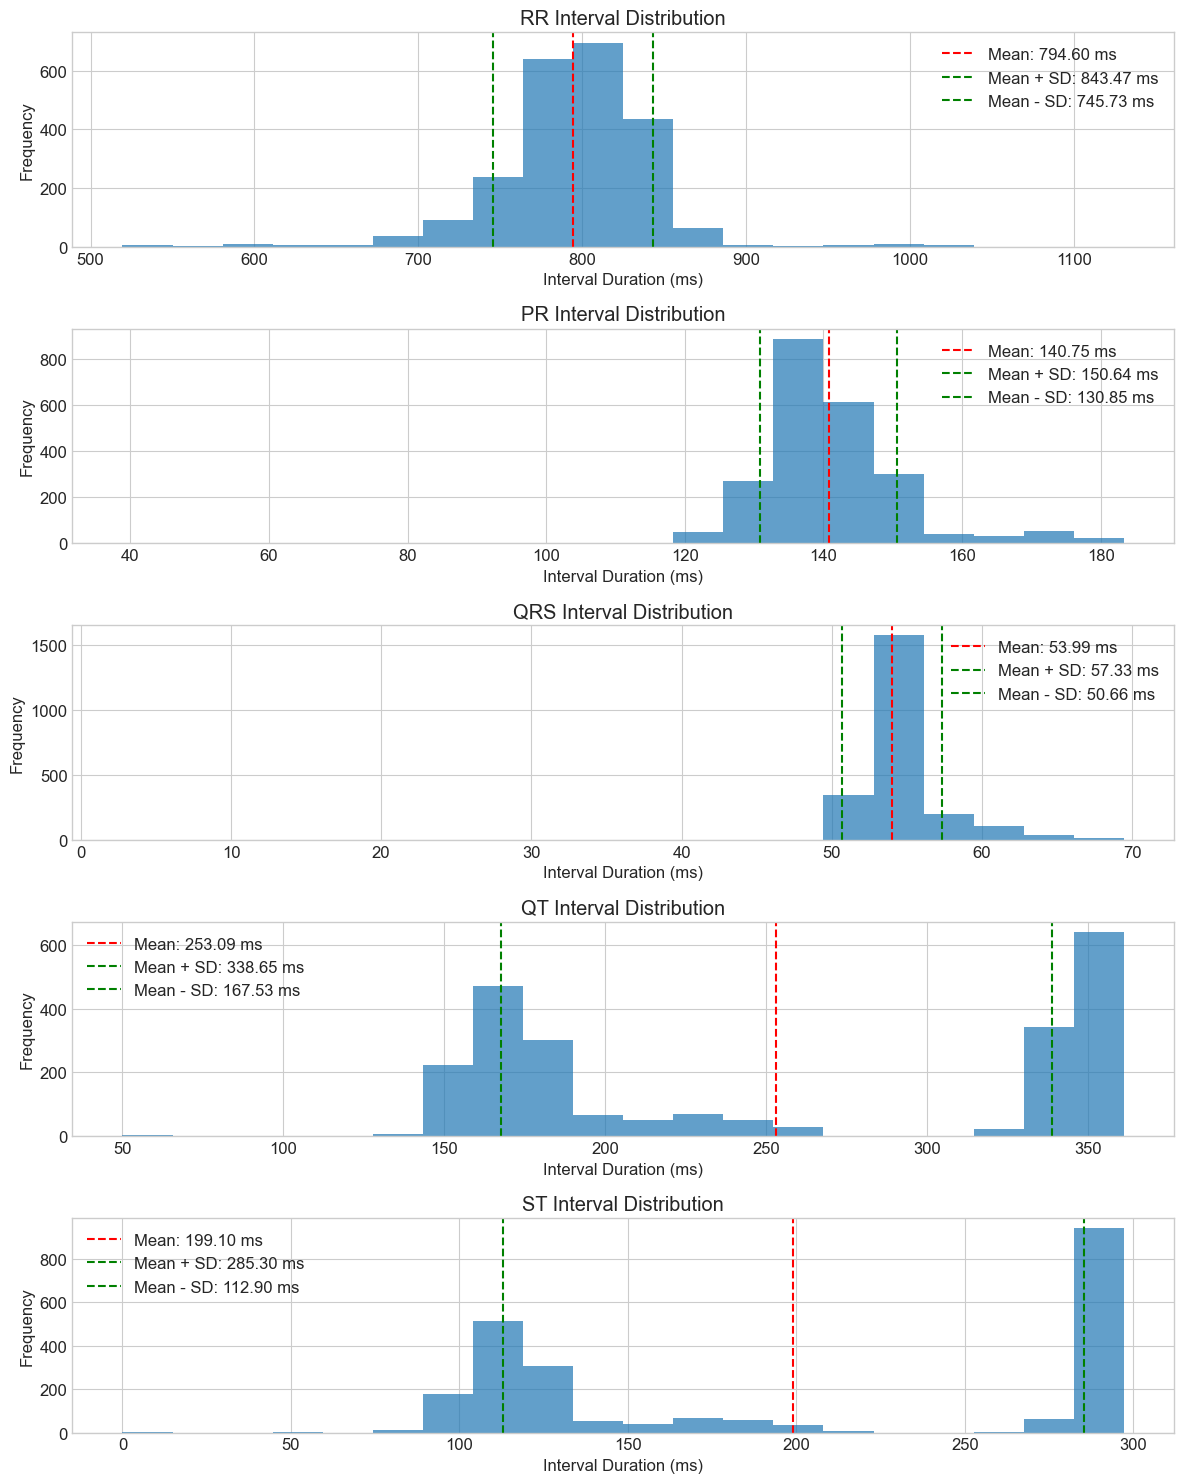

In [12]:
# %% Cell 11: Visualize ECG Intervals
# Plot ECG interval distributions
interval_list = ['RR', 'PR', 'QRS', 'QT', 'ST']
available_intervals = [interval for interval in interval_list if interval in ecg_intervals]

if available_intervals:
    # Create subplots for each interval
    num_intervals = len(available_intervals)
    fig, axes = plt.subplots(num_intervals, 1, figsize=(12, 3*num_intervals))
    
    if num_intervals == 1:
        axes = [axes]  # Make axes iterable if only one interval
    
    for i, interval in enumerate(available_intervals):
        interval_data = ecg_intervals[interval]
        axes[i].hist(interval_data, bins=20, alpha=0.7)
        axes[i].axvline(x=np.mean(interval_data), color='r', linestyle='--', 
                        label=f'Mean: {np.mean(interval_data):.2f} ms')
        axes[i].axvline(x=np.mean(interval_data) + np.std(interval_data), color='g', linestyle='--', 
                        label=f'Mean + SD: {np.mean(interval_data) + np.std(interval_data):.2f} ms')
        axes[i].axvline(x=np.mean(interval_data) - np.std(interval_data), color='g', linestyle='--', 
                        label=f'Mean - SD: {np.mean(interval_data) - np.std(interval_data):.2f} ms')
        axes[i].set_title(f"{interval} Interval Distribution")
        axes[i].set_xlabel("Interval Duration (ms)")
        axes[i].set_ylabel("Frequency")
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()


In [13]:
# %% Cell 12: Segment Heartbeats
def segment_heartbeats(ecg_signal, r_peaks, fs, before_r=0.25, after_r=0.45):
    """
    Segment heartbeats centered around R peaks.
    
    Parameters:
        ecg_signal: The ECG signal
        r_peaks: Array of R-peak indices
        fs: Sampling frequency
        before_r: Time before R peak in seconds
        after_r: Time after R peak in seconds
        
    Returns:
        Array of segmented heartbeats
    """
    # Convert times to samples
    before_samples = int(before_r * fs)
    after_samples = int(after_r * fs)
    segment_length = before_samples + after_samples
    
    # Initialize array to store heartbeats
    heartbeats = []
    valid_r_peaks = []
    
    # Extract heartbeats
    for r_peak in r_peaks:
        # Check if we can extract a complete segment
        if r_peak >= before_samples and r_peak + after_samples <= len(ecg_signal):
            # Extract segment
            segment = ecg_signal[r_peak - before_samples:r_peak + after_samples]
            heartbeats.append(segment)
            valid_r_peaks.append(r_peak)
    
    return np.array(heartbeats), np.array(valid_r_peaks)

# Segment heartbeats using XQRS R-peaks
channel_to_analyze = 0  # Analyze the first channel
heartbeats, valid_r_peaks = segment_heartbeats(ecg_processed[:, channel_to_analyze], r_peaks_xqrs, fs)

print(f"Segmented {len(heartbeats)} heartbeats")


Segmented 2271 heartbeats


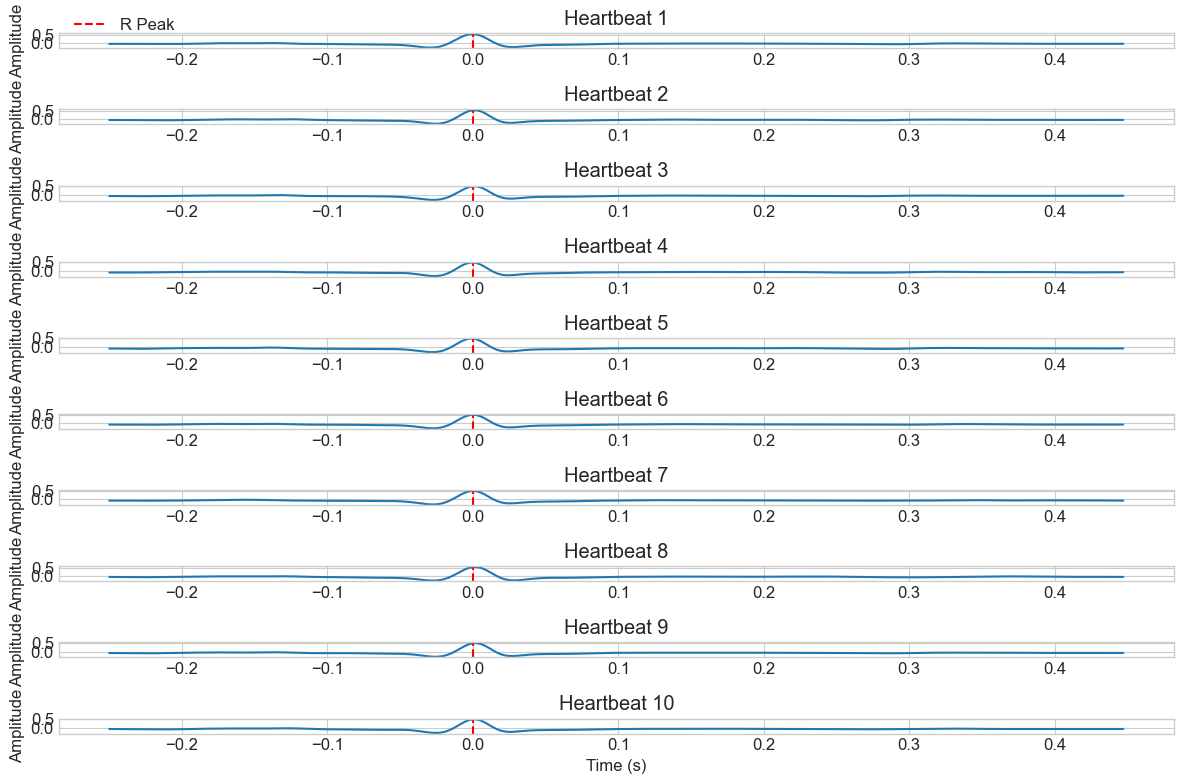

In [14]:
# %% Cell 13: Visualize Segmented Heartbeats
# Plot a subset of segmented heartbeats
num_beats_to_plot = min(10, len(heartbeats))

plt.figure(figsize=(12, 8))

# Plot individual heartbeats
for i in range(num_beats_to_plot):
    plt.subplot(num_beats_to_plot, 1, i+1)
    
    # Create time array for the beat
    beat_time = np.arange(-0.25, 0.45, 1/fs)[:len(heartbeats[i])]
    
    plt.plot(beat_time, heartbeats[i])
    plt.axvline(x=0, color='r', linestyle='--', label='R Peak')
    plt.title(f"Heartbeat {i+1}")
    plt.xlabel("Time (s)" if i == num_beats_to_plot-1 else "")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    # Only show legend for first subplot
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

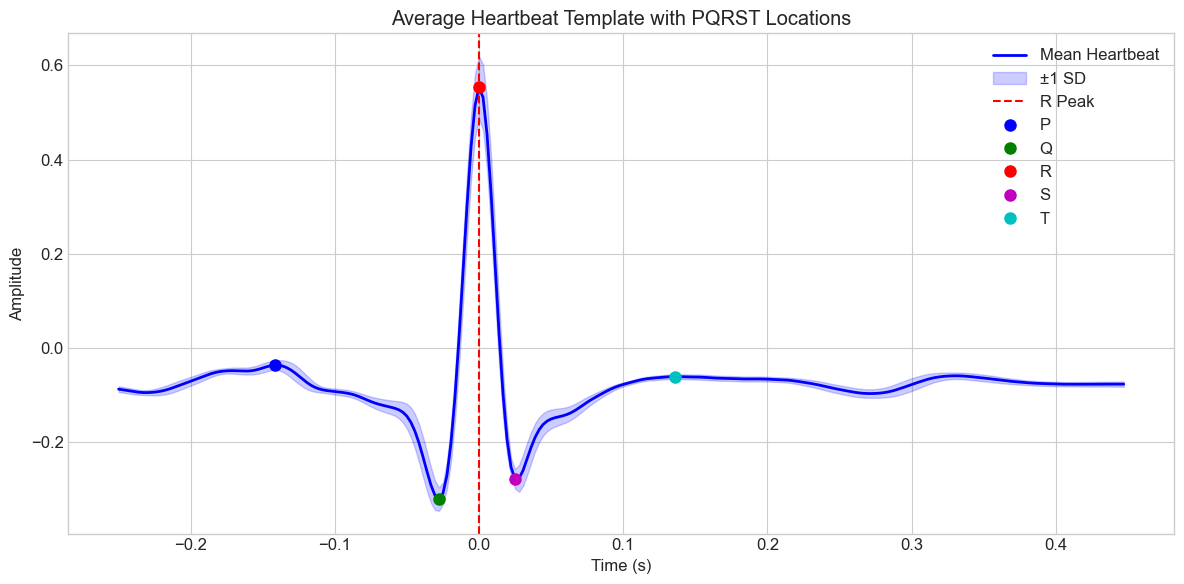

In [15]:
# %% Cell 14: Visualize Heartbeat Template
# Create a template heartbeat by averaging all segmented beats
template_beat = np.mean(heartbeats, axis=0)
template_std = np.std(heartbeats, axis=0)

# Create time array for template beat
beat_time = np.arange(-0.25, 0.45, 1/fs)[:len(template_beat)]

plt.figure(figsize=(12, 6))
plt.plot(beat_time, template_beat, 'b-', linewidth=2, label='Mean Heartbeat')
plt.fill_between(beat_time, 
                 template_beat - template_std, 
                 template_beat + template_std, 
                 color='b', alpha=0.2, label='±1 SD')

# Mark the R-peak
plt.axvline(x=0, color='r', linestyle='--', label='R Peak')

# Try to estimate PQRST locations on the template
p_idx = np.argmax(template_beat[:int(0.2*fs)])  # P wave typically before R
q_idx = np.argmin(template_beat[int(0.2*fs):int(0.25*fs)]) + int(0.2*fs)  # Q is the minimum just before R
r_idx = int(0.25*fs)  # R peak is at t=0
s_idx = np.argmin(template_beat[r_idx:r_idx+int(0.05*fs)]) + r_idx  # S is minimum just after R
t_idx = np.argmax(template_beat[s_idx:s_idx+int(0.2*fs)]) + s_idx  # T is maximum after S

# Mark PQRST points
plt.plot(beat_time[p_idx], template_beat[p_idx], 'bo', markersize=8, label='P')
plt.plot(beat_time[q_idx], template_beat[q_idx], 'go', markersize=8, label='Q')
plt.plot(beat_time[r_idx], template_beat[r_idx], 'ro', markersize=8, label='R')
plt.plot(beat_time[s_idx], template_beat[s_idx], 'mo', markersize=8, label='S')
plt.plot(beat_time[t_idx], template_beat[t_idx], 'co', markersize=8, label='T')

plt.title("Average Heartbeat Template with PQRST Locations")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# %% Cell 15: Save Detection Results
# Create output directory if it doesn't exist
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Save PQRST peaks
pqrst_df = pd.DataFrame()
for wave, indices in pqrst_peaks.items():
    pqrst_df[f"{wave}_peaks"] = pd.Series(indices)

# Continuation of Cell 15: Save Detection Results
pqrst_df.to_csv(os.path.join(output_dir, 'pqrst_peaks.csv'), index=False)
print(f"Saved PQRST peak indices to {os.path.join(output_dir, 'pqrst_peaks.csv')}")

# Save heartbeat segments
np.save(os.path.join(output_dir, 'heartbeat_segments.npy'), heartbeats)
print(f"Saved {len(heartbeats)} heartbeat segments to {os.path.join(output_dir, 'heartbeat_segments.npy')}")

# Save ECG intervals
intervals_df = pd.DataFrame()
for interval_name, values in ecg_intervals.items():
    if not interval_name.endswith('_mean') and not interval_name.endswith('_std'):
        intervals_df[interval_name] = pd.Series(values)

# Add summary statistics
summary_stats = {key: [value] for key, value in ecg_intervals.items() 
                 if key.endswith('_mean') or key.endswith('_std')}
summary_df = pd.DataFrame(summary_stats)

# Save to CSV files
intervals_df.to_csv(os.path.join(output_dir, 'ecg_intervals.csv'), index=False)
summary_df.to_csv(os.path.join(output_dir, 'ecg_interval_stats.csv'), index=False)

print(f"Saved ECG interval data to {output_dir}")
print("Peak detection and analysis completed successfully!")

Saved PQRST peak indices to ../data/processed\pqrst_peaks.csv
Saved 2271 heartbeat segments to ../data/processed\heartbeat_segments.npy
Saved ECG interval data to ../data/processed
Peak detection and analysis completed successfully!
